In [2]:
import pycaret
import sklearn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
datatype = {"country": object,
            "industry_claim": object,  
            "industry_other":  object, 
            "industry_reno": object, 
            "industry_surveys": object,
            "industry_surveys":  object,
            "marketing_intent": object,
            "marketing_team": object, 
            "marketing_use_case": object,
            "first_device_lidar": object,
            "agg_first_room_create_method": object,
            #"converted": object
           }

In [4]:
df = pd.read_csv('train-0906.csv',dtype=datatype)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125131 entries, 0 to 125130
Data columns (total 34 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   user_id                                 125131 non-null  object
 1   country                                 125126 non-null  object
 2   sign_up_os                              125131 non-null  object
 3   marketing_use_case                      70514 non-null   object
 4   marketing_intent                        70526 non-null   object
 5   industry_claim                          125131 non-null  object
 6   industry_other                          125131 non-null  object
 7   industry_reno                           125131 non-null  object
 8   industry_surveys                        125131 non-null  object
 9   marketing_team                          125131 non-null  object
 10  sign_up_time                            125131 non-null 

In [6]:
df.sign_up_time.min()

'2022-04-01 00:19:58.928 UTC'

In [7]:
df.sign_up_time.max()

'2023-06-09 08:54:20.241 UTC'

In [9]:
# compare these three values for each user: first_camera_time, first_square_time, first_corners_time
# categories: camera, square, corners, no_creation
def conditions(df):
    if ((df['first_camera_time_ios'] is not pd.NaT) and (df['first_camera_time_ios'] <= df['first_corners_time_ios'] or (df['first_corners_time_ios'] is pd.NaT)) and (df['first_camera_time_ios'] <= df['first_square_time_ios'] or (df['first_square_time_ios'] is pd.NaT))) :
        return 'camera'
    elif ((df['first_square_time_ios'] is not pd.NaT) and (df['first_square_time_ios'] <= df['first_corners_time_ios'] or (df['first_corners_time_ios'] is pd.NaT)) and (df['first_square_time_ios'] <= df['first_camera_time_ios'] or (df['first_camera_time_ios'] is pd.NaT) )):
        return 'square'
    elif ((df['first_corners_time_ios'] is not pd.NaT) and (df['first_corners_time_ios'] <= df['first_camera_time_ios'] or (df['first_camera_time_ios'] is pd.NaT)) and (df['first_corners_time_ios'] <= df['first_square_time_ios']  or (df['first_square_time_ios'] is pd.NaT))):
        return 'corners'
    else:
        return 'no_creation'

In [10]:
# this preprocess function is written for test data
# we need to create new features also from raw test data 

def preprocess(df_raw):
    df = df_raw.copy()
    df['application_opened_ios'] = df['application_opened_ios']+1
    
    df['sign_up_time'] = pd.to_datetime(df['sign_up_time'], errors='coerce')
    df['first_project_time_ios'] = pd.to_datetime(df['first_project_time_ios'], errors='coerce')
    df['first_room_time_ios'] = pd.to_datetime(df['first_room_time_ios'], errors='coerce')
    df['first_camera_time_ios'] = pd.to_datetime(df['first_camera_time_ios'], errors='coerce')
    df['first_square_time_ios'] = pd.to_datetime(df['first_square_time_ios'], errors='coerce')
    df['first_corners_time_ios'] = pd.to_datetime(df['first_corners_time_ios'], errors='coerce')
    df['first_export_time_ios'] = pd.to_datetime(df['first_export_time_ios'], errors='coerce')
    
    # calculate the difference between that action timestamp and sign_up timestamp
    # create aggreagated time features: (minutes)
    agg_names = ['first_project_time_diff','first_room_time_diff','first_camera_time_diff',
                 'first_square_time_diff','first_corners_time_diff','first_export_time_diff']
    cols = ['first_project_time_ios','first_room_time_ios','first_camera_time_ios','first_square_time_ios',
            'first_corners_time_ios','first_export_time_ios' ]
  
    for i in range (len(agg_names)):
        df[agg_names[i]] = (df[cols[i]] - df['sign_up_time']).dt.total_seconds() / 60
        df.loc[df[agg_names[i]] < 0, agg_names[i]] = np.nan

    # create another feature: 
    # conditions defined in another function
    df['agg_first_room_create_method'] = df.apply(conditions, axis=1)
    
    # create another feature:
    # get the time difference between first_project_time and first_room_time  (minutes)
    # to know how long it takes the user to create a room after it figures out how to create a project 
    df['diff_first_project_room'] = (df['first_room_time_ios'] - df['first_project_time_ios']).dt.total_seconds()/ 60
    df.loc[df['diff_first_project_room'] < 0, 'diff_first_project_room'] = np.nan

    # drop unnessary columns
    drop_features= ['sign_up_os','sign_up_time','first_project_time_ios','first_room_time_ios',
                    'first_camera_time_ios','first_square_time_ios','first_corners_time_ios','first_export_time_ios']
    
    df.drop(columns=drop_features , inplace = True)
    
    return df

In [8]:
df.converted.value_counts()

0    122299
1      2832
Name: converted, dtype: int64

In [11]:
df_p = preprocess(df)

In [12]:
df_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125131 entries, 0 to 125130
Data columns (total 34 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   user_id                                 125131 non-null  object 
 1   country                                 125126 non-null  object 
 2   marketing_use_case                      70514 non-null   object 
 3   marketing_intent                        70526 non-null   object 
 4   industry_claim                          125131 non-null  object 
 5   industry_other                          125131 non-null  object 
 6   industry_reno                           125131 non-null  object 
 7   industry_surveys                        125131 non-null  object 
 8   marketing_team                          125131 non-null  object 
 9   first_device_model                      117112 non-null  object 
 10  first_device_type                       1171

In [13]:
df_p = df_p[['user_id','converted',"first_project_time_diff","first_room_time_diff",
                "first_camera_time_diff","first_square_time_diff","first_corners_time_diff",
                "first_export_time_diff","application_opened_ios","application_updated_ios",
                "project_created_ios","room_creation_succeeded_ios","room_method_corners_ios",
                "room_method_camera_ios","room_method_square_ios","project_export_succeeded_ios",
                "diff_first_project_room","marketing_use_case","marketing_intent","industry_claim","industry_other",
                "industry_reno","industry_surveys","marketing_team","first_device_type","first_device_lidar",
                "agg_first_room_create_method",'country','first_device_model']]

In [14]:
num_features = ["first_project_time_diff","first_room_time_diff",
                "first_camera_time_diff","first_square_time_diff","first_corners_time_diff",
                "first_export_time_diff","application_opened_ios","application_updated_ios",
                "project_created_ios","room_creation_succeeded_ios","room_method_corners_ios",
                "room_method_camera_ios","room_method_square_ios","project_export_succeeded_ios",
                "diff_first_project_room"]
cat_features = ["marketing_use_case","marketing_intent","industry_claim","industry_other",
                "industry_reno","industry_surveys","marketing_team","first_device_type","first_device_lidar",
                "agg_first_room_create_method"]

# Classification

In [15]:
# Random Undersampling 
df_1 = df_p.loc[df_p['converted'] == 1].reset_index()
df_0 = df_p.loc[df_p['converted'] == 0].reset_index()
df_1 = df_1.drop('index', axis=1)
df_0 = df_0.drop('index', axis=1)

In [16]:
class_count_0, class_count_1 = df_p['converted'].value_counts()
print(class_count_0,"-", class_count_1)

122299 - 2832


In [17]:
df_1.shape

(2832, 29)

In [18]:
df_0_sampled = df_0.sample(class_count_1)

In [19]:
df_balanced = pd.concat([df_1, df_0_sampled], ignore_index=True, sort=False)

In [20]:
df_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5664 entries, 0 to 5663
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   user_id                       5664 non-null   object 
 1   converted                     5664 non-null   int64  
 2   first_project_time_diff       3051 non-null   float64
 3   first_room_time_diff          2670 non-null   float64
 4   first_camera_time_diff        1611 non-null   float64
 5   first_square_time_diff        1939 non-null   float64
 6   first_corners_time_diff       1265 non-null   float64
 7   first_export_time_diff        591 non-null    float64
 8   application_opened_ios        5664 non-null   int64  
 9   application_updated_ios       5664 non-null   int64  
 10  project_created_ios           5664 non-null   int64  
 11  room_creation_succeeded_ios   5664 non-null   int64  
 12  room_method_corners_ios       5664 non-null   int64  
 13  roo

In [35]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_balanced, test_size=0.2)

In [36]:
print(train.shape)
print(test.shape)

(4531, 29)
(1133, 29)


In [37]:
from pycaret.classification import *

s = setup(data= train, 
          target='converted',
          normalize=True,         
          remove_outliers=True, 
          silent=True,
          normalize_method='robust',
          categorical_imputation='constant',
          numeric_imputation='mean',
          ignore_features=['user_id'], #key 
          high_cardinality_features=['country','first_device_model'],
          numeric_features= num_features,
          categorical_features=cat_features,
          combine_rare_levels = True,
          ignore_low_variance = True,              
          outliers_threshold = 0.01,
          remove_multicollinearity=True,
          feature_selection = True,
          feature_selection_threshold = 0.85,
          fold = 5,  # cross validation
          n_jobs = -1,
          session_id=123)

,Description,Value
0,session_id,123
1,Target,converted
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(4531, 29)"
5,Missing Values,True
6,Numeric Features,15
7,Categorical Features,12
8,Ordinal Features,False
9,High Cardinality Features,True


In [46]:
best_model = compare_models()  # greater is better for all types...

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7518,0.8244,0.7497,0.7484,0.7489,0.5036,0.5038,0.1080
ada,Ada Boost Classifier,0.7397,0.8057,0.7548,0.7285,0.7412,0.4796,0.4803,0.0500
lightgbm,Light Gradient Boosting Machine,0.7378,0.8089,0.7303,0.7367,0.7333,0.4755,0.4758,0.0480
rf,Random Forest Classifier,0.7314,0.8048,0.6897,0.7473,0.7172,0.4623,0.4638,0.1180
et,Extra Trees Classifier,0.7095,0.7778,0.6710,0.7218,0.6951,0.4183,0.4197,0.1020
ridge,Ridge Classifier,0.7025,0.0000,0.6845,0.7047,0.6943,0.4046,0.4049,0.0120
lda,Linear Discriminant Analysis,0.7025,0.7692,0.6845,0.7047,0.6943,0.4046,0.4049,0.0120
knn,K Neighbors Classifier,0.6970,0.7598,0.6826,0.6976,0.6898,0.3938,0.3941,0.4080
lr,Logistic Regression,0.6725,0.7291,0.7168,0.6539,0.6837,0.3457,0.3475,0.6280
dt,Decision Tree Classifier,0.6620,0.6628,0.6503,0.6600,0.6548,0.3238,0.3241,0.0120


In [47]:
algos = ['lightgbm', 'rf','gbc', 'ada'] # models with recall > %70
best_choosen = compare_models(include = algos, n_select = len(algos), sort = 'recall')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.7397,0.8057,0.7548,0.7285,0.7412,0.4796,0.4803,0.0480
gbc,Gradient Boosting Classifier,0.7518,0.8244,0.7497,0.7484,0.7489,0.5036,0.5038,0.1200
lightgbm,Light Gradient Boosting Machine,0.7378,0.8089,0.7303,0.7367,0.7333,0.4755,0.4758,0.0460
rf,Random Forest Classifier,0.7314,0.8048,0.6897,0.7473,0.7172,0.4623,0.4638,0.1260


In [49]:
best_model = best_choosen[1]
best_model

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [50]:
m = create_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7452,0.8067,0.7484,0.7389,0.7436,0.4904,0.4905
1,0.7643,0.8433,0.7452,0.7700,0.7574,0.5284,0.5287
2,0.7357,0.8193,0.7258,0.7353,0.7305,0.4712,0.4712
3,0.7548,0.8282,0.7516,0.7516,0.7516,0.5095,0.5095
4,0.7592,0.8243,0.7774,0.7461,0.7615,0.5185,0.5190
Mean,0.7518,0.8244,0.7497,0.7484,0.7489,0.5036,0.5038
Std,0.0102,0.0119,0.0165,0.0122,0.0110,0.0205,0.0206


# Hyperparameter Tuning

In [51]:
# defining search space (random & grid)
params = {"max_depth": np.random.randint(1, (len(df.columns)*.85),10),
          "max_features": np.random.randint(1, len(df.columns),10),
          "min_samples_leaf": [1,2,3,4]}

In [52]:
# this function tunes the hyperparameters of the model
# the output of this function is a scoring grid with cross-validated scores by fold
tuned_model = tune_model(m,
                      n_iter = 20,
                      optimize='recall', #the best model is selected based on the recall metric
                      search_library='scikit-learn',
                      custom_grid = params,
                      #return_tuner=True,
                      choose_better=True)
# if hyperparameter tuning doesn't improve the performance, choose_better will return the input model

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7357,0.8052,0.7484,0.7250,0.7365,0.4715,0.4717
1,0.7707,0.8473,0.7516,0.7767,0.7639,0.5411,0.5414
2,0.7500,0.8218,0.7484,0.7460,0.7472,0.4999,0.4999
3,0.7564,0.8349,0.7452,0.7574,0.7512,0.5126,0.5126
4,0.7528,0.8250,0.7677,0.7414,0.7544,0.5057,0.5060
Mean,0.7531,0.8269,0.7523,0.7493,0.7506,0.5062,0.5063
Std,0.0113,0.0140,0.0080,0.0172,0.0090,0.0224,0.0224


In [53]:
tuned_model

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=26, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=3, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

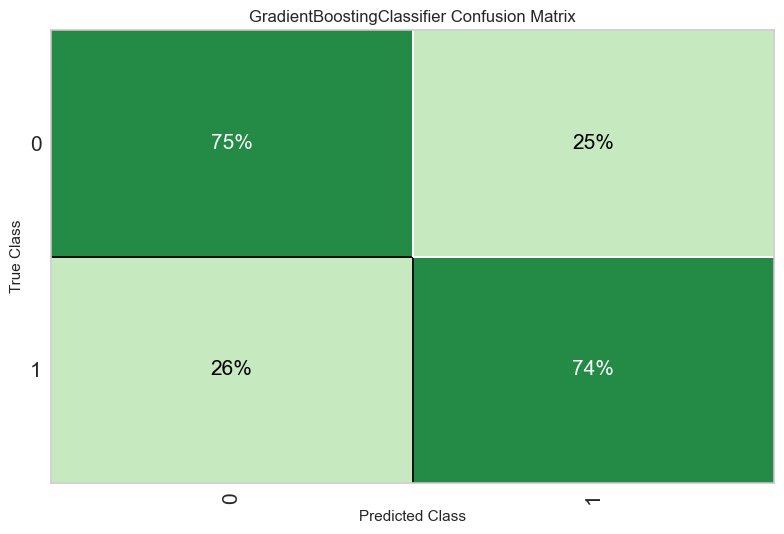

In [54]:
plot_model(tuned_model, plot = 'confusion_matrix', plot_kwargs = {'percent' : True})

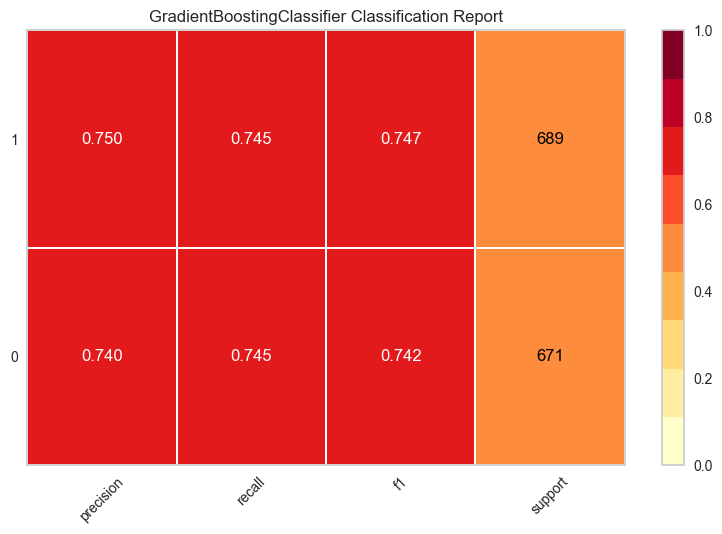

In [56]:
plot_model(tuned_model, plot = 'class_report')

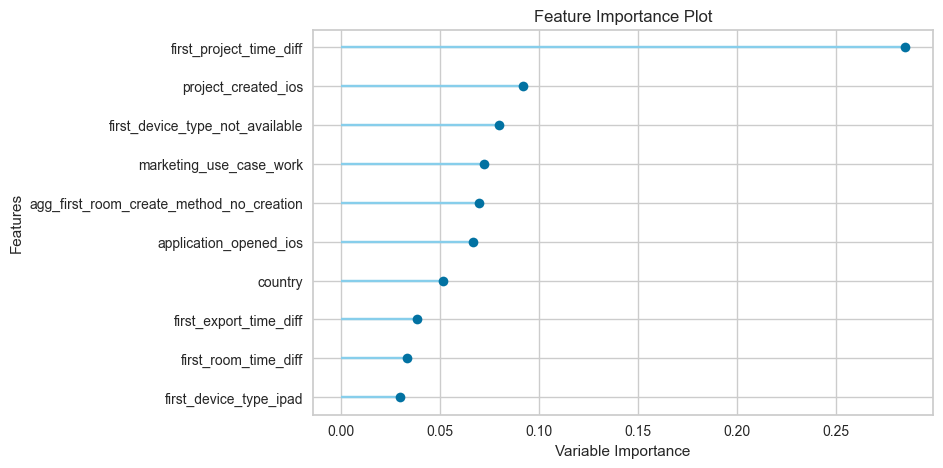

In [55]:
plot_model(tuned_model, plot = 'feature')

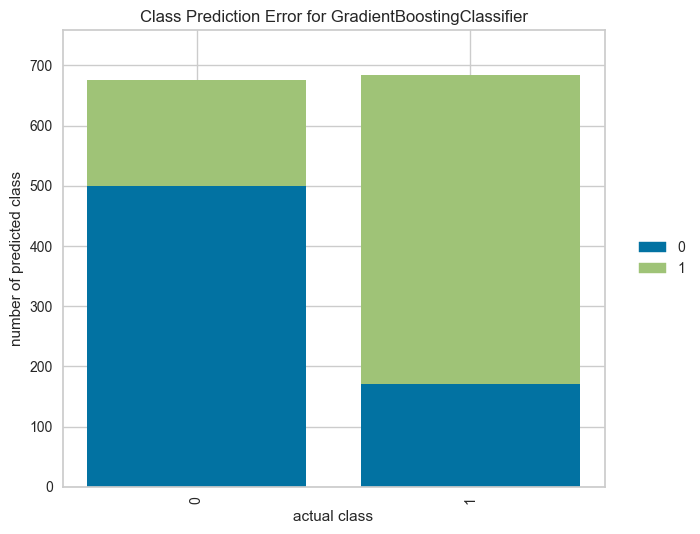

In [57]:
plot_model(tuned_model, plot = 'error')

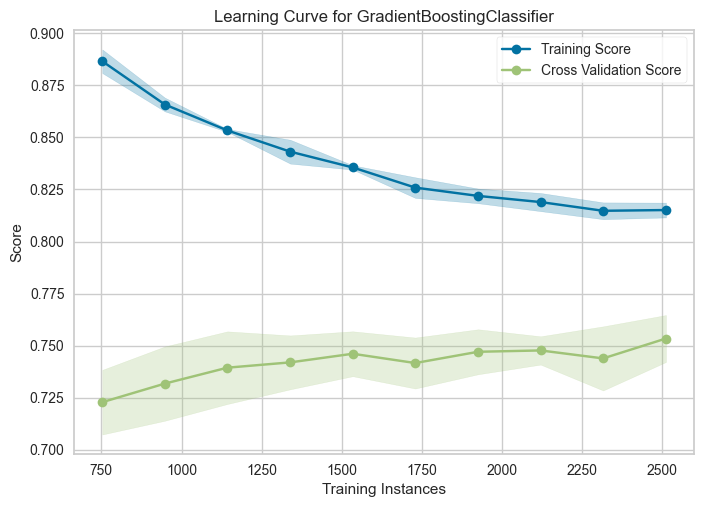

In [58]:
plot_model(tuned_model, plot = 'learning')

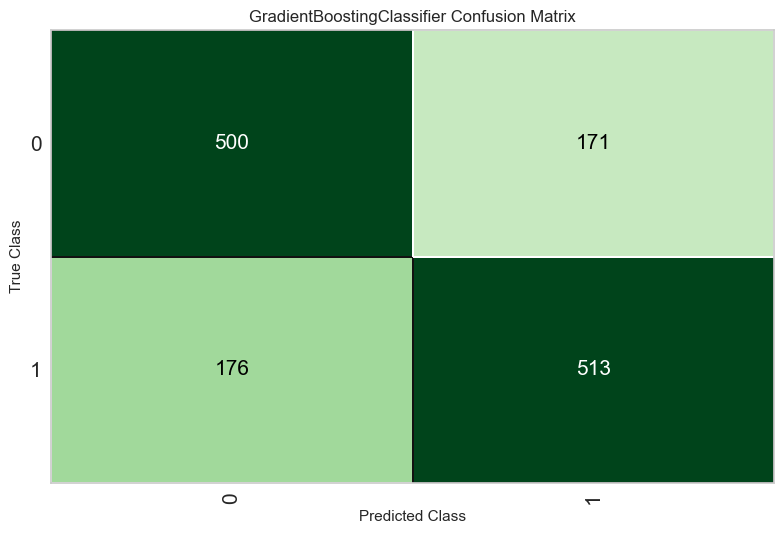

In [59]:
plot_model(tuned_model, plot = 'confusion_matrix')

In [60]:
save_model(tuned_model, 'model-v2') 

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['marketing_use_case',
                                                             'marketing_intent',
                                                             'industry_claim',
                                                             'industry_other',
                                                             'industry_reno',
                                                             'industry_surveys',
                                                             'marketing_team',
                                                             'first_device_type',
                                                             'first_device_lidar',
                                                             'agg_first_room_create_method'],
                                       display_types=False,
                                       features_todrop=['user_id'],
  

In [61]:
from pycaret.classification import load_model 

saved = load_model('model-v2') 

saved

Transformation Pipeline and Model Successfully Loaded


Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=['marketing_use_case',
                                                            'marketing_intent',
                                                            'industry_claim',
                                                            'industry_other',
                                                            'industry_reno',
                                                            'industry_surveys',
                                                            'marketing_team',
                                                            'first_device_type',
                                                            'first_device_lidar',
                                                            'agg_first_room_create_method'],
                                      display_types=False,
                                      features_todrop=['user_id'],
                

In [62]:
df_tested = predict_model(saved, data = test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.7379,0.8147,0.7183,0.7536,0.7355,0.4760,0.4765
